# Analyzing water levels of the river Isar

In light of the recent flooding catastrophe with more than 170 dead, my interest sparked in monitoring and maybe predicting the water levels of the river in my hometown Munich, the river Isar.

In this project you will get an idea how I refine my workflow and the identification of interesting data. I will also improve my skills in web scraping and time series analysis.

## Project goal and motivation

I started this project to improve and expand two skillsets in my data science toolbox:

Tools and workflow technologies
- Visual Studio Code
- Github
- Python scripting

Data science subject
- Time Series analysis
- Time Series forecasting

Also, I see it as a portfolio project, highlighting my current skills in the above-mentioned subjects, story telling and general Python programming. I will probably  
use a lot of resources from practitioners, learners, professionals and amateurs. For this reason I want to share my project and the insights I've gained with you and  
I'm more than curious about your comments, suggestions and enhancements.

The project is structured in three main parts:

1. Problem formulation and subject understanding
2. Data source identification and web scraping
3. Data wrangling and time series analysis

Acknowledgements

## 0. Loading packages

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from datetime import datetime, timedelta
from datetime import date

#configure visualization
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
plt.style.use('seaborn-paper')


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['figure.figsize'] = 10, 6

now = datetime.today()

import os
from os import walk
dirname = os.getcwd()

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
#Script handling parameters
scraping = True
concatenating = True
deleting_scraped_files = True
save_to = 'CSV'
using_sql = False

In [3]:
#csv date format
format_1 = '%Y-%m-%d %H:%M:%S'
#website date format
format_2 = '%d.%m.%Y, %H:%M'
#fallback website date format
format_3 = '%d.%m. %H:%M'

## 1. Problem formulation and subject understanding

The isar is a 292,3 kilometer long river that originates in the very north of Austria. The river crosses the capital of bavaria Munich until it merges with the Donau river south of Deggendorf. [Source: wikipedia.com/isar]



# 1. Data collecting phase

## 1.1. Data Source identification

The bavarian ministry for envoironment runs the so called "Hochwassernachrichtendienst" HND where the water levels of several rivers and lakes are provided. Additionally there are information on precipication and others.

We focus on scraping the water levels first. The site is structured as follows

    Basic Link:           https://www.hnd.bayern.de/pegel/meldestufen/isar/tabellen
    Additional Parameter: ?days=0&hours=1

We can address the levels per day for the last 30 days while 0 is today and 29 the oldest. The data is provided on an hourly interval from 0 to 23. For now, we don't need the most recent data, but this might change when  
upgrading to a more sophisticated scraping approach. At the moment we focus on getting a basic scrapping to work.

In [4]:
#Web scraping properties
#link = "https://www.hnd.bayern.de/pegel/meldestufen/isar/tabellen?days=0&hours=1"
basic_link = "https://www.hnd.bayern.de/pegel/tabellen"

## 1.2. Web scraping

Currently we scrap the full month of data and discarge the duplicates when we merge the DataFrames. This leads to a unneccessary long scraping time.  
In order to reduce the scapring time we want to determine which days need to be scraped by comparing the difference between the recent data and the   
current date.

In [5]:
#list history file and read as df
for file_name in os.listdir():
    if 'bay_river_pegel' and '.csv' in file_name:
        hist_pegel = pd.read_csv(file_name, parse_dates=True)
        hist_pegel['datumzeit'] = pd.to_datetime(hist_pegel['datumzeit'], format='%Y-%m-%d %H:%M:%S')
        last_scraped_datetime = hist_pegel['datumzeit'][0]
        
        #determine the range of days to scrape
        days_scrape  = [i for i in range(0,((now - last_scraped_datetime).days + 1))]
        break
    else:
        #full scrape if no history available
        hist_pegel = None
        days_scrape  = [i for i in range(0,31)]


#full hours to scrape
hours_scrape = [i for i in range(0,24)]


In [6]:
#File handling properties
von_string = str(date.today() - timedelta(days_scrape[-1]))
bis_string = str(date.today() - timedelta(days_scrape[0]))
path = dirname + "/ScrapingData/"

save_string = 'bay_river_pegel' + '_' + von_string +  '_bis_' + bis_string

As you can see, pandas 'read_html' class is a very powerful tool to get html tabels quickly into a dataframe. We now automate this approach to scrape the full history of the water levels.

In [8]:
#Web scraping
if scraping:
    df_water_levels_scrape = pd.DataFrame()
    
    #add handling for most recent data
    for day in days_scrape:
        #when today, only scrape to current hour
        if day == 0:

            for hour in hours_scrape:
                if hour <= (now.hour - 1):
                    try:
                        scrape_link = basic_link + '?days=' + str(day) + '&hours=' + str(hour)
                        water_level = pd.read_html(scrape_link)
                        df_water_levels_scrape = df_water_levels_scrape.append(water_level[0])
                    except ValueError:
                        pass
        #when past days, scrape full hours
        else:
            for hour in hours_scrape:
                try:
                    scrape_link = basic_link + '?days=' + str(day) + '&hours=' + str(hour)
                    water_level = pd.read_html(scrape_link)
                    df_water_levels_scrape = df_water_levels_scrape.append(water_level[0])
                except ValueError:
                    pass

    #df_water_levels_scrape['Datum Zeit'] = pd.to_datetime(df_water_levels_scrape['Datum Zeit'], format='%d.%m.%Y, %H:%M')
    df_water_levels_scrape.to_csv((path + save_string + '.csv'), index=False)

## 1.3 Concatenate scraped files

Since scraping writes the data independently to the disk, the following code 
concatenates the scraped file into a dataframe. The module also performs some
cleaning steps, especially:

- formatting of column names
- handling of nan-values
- handling duplicates
- optimizing dtype

This dataframe can be used to perform further analysis or to save the complete data  
to disk.

In [9]:
#concat files in the scraping folder into a single df

if concatenating == True:
    #list files in the scraping folder and concat to single df
    scraped_files       = os.listdir(path)
    df_from_each_file   = (pd.read_csv(path + f) for f in scraped_files)
    concatenated_df     = pd.concat(df_from_each_file, axis=0, ignore_index=True)


    #formatting of column names
    concatenated_df.columns = concatenated_df.columns.str.replace(' ','')
    concatenated_df.columns = concatenated_df.columns.str.replace('[^a-zA-ZäÄöÖüÜ0-9,]', '', regex=True)
    concatenated_df.columns = concatenated_df.columns.str.lower()

    #search for non available data and leave these data points out. We do this step only on newly scraped data
    missing_string = ['Derzeit leider keine aktuellen Daten vorhanden.',
                      'Keine Datenfernübertragung, Meldung nur im Hochwasserfall.']
    concatenated_df = concatenated_df[~concatenated_df.isin(missing_string)]
    
    #datetime formating from the websites date format
    #some stations report different time formats
    for index, row in concatenated_df.iterrows():
        try:
            row['datumzeit'] = pd.to_datetime(row['datumzeit'], format=format_2)
        except ValueError:
            row['datumzeit'] = pd.to_datetime(row['datumzeit'], format=format_3)
            row['datumzeit'] = row['datumzeit'].replace(year=2022)

    
    #Subset because there are NaN in column "Vorhersage", which would drop everything
    concatenated_df = concatenated_df.dropna(subset=['wasserstandcm'])

    #sort and drop duplicates
    concatenated_df     = concatenated_df.sort_values(by=['datumzeit'], ascending = True)
    concatenated_df     = concatenated_df.drop_duplicates(['messstelle','datumzeit'])

    #concat concatenated files and recent scraping
    concatenated_df_2     = pd.concat([hist_pegel, concatenated_df], axis=0, ignore_index=True)
    concatenated_df_2     = concatenated_df_2.sort_values(by=['datumzeit'], ascending = False)

    #Clean up by dropping duplicates in observation point and datetime
    concatenated_df_2   = concatenated_df_2.drop_duplicates(['messstelle','datumzeit'])

    #correct dtype
    #we remove non number values to avoid saving data as object
    concatenated_df_2['datumzeit'] = pd.to_datetime(concatenated_df_2['datumzeit'], format=format_2)
    concatenated_df_2['wasserstandcm'] = concatenated_df_2['wasserstandcm'].replace('---', 0)
    concatenated_df_2['wasserstandcm'].astype(np.float64)
    concatenated_df_2['änderungseit2stdcm'] = concatenated_df_2['änderungseit2stdcm'].replace('---', 0)
    concatenated_df_2['änderungseit2stdcm'].astype(np.int8)
    concatenated_df_2['abflussms'] = concatenated_df_2['abflussms'].replace('---', 0)
    concatenated_df_2['abflussms'].astype(np.float64)
    concatenated_df_2['meldestufe'] = concatenated_df_2['meldestufe'].replace('---', 0)
    concatenated_df_2['meldestufe'].astype(np.int8)
  
   

In [10]:
concatenated_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4824779 entries, 4824783 to 4441644
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   messstelle          object        
 1   gewässer            object        
 2   datumzeit           datetime64[ns]
 3   wasserstandcm       object        
 4   änderungseit2stdcm  object        
 5   abflussms           object        
 6   meldestufe          object        
 7   jährlichkeit        object        
 8   vorhersage          object        
dtypes: datetime64[ns](1), object(8)
memory usage: 368.1+ MB


Since our scraping works as intended, we take the time to persistently save the complete data to disk.

Since our scraping works as intended, we take the time to investigate the outcome. In theory, there should be 24 obersvations per day and oberservation point. We check this by saving an oberservation point to a dedicated DataFrame and group by date.

In [11]:
waterlevel_sylvenstein = concatenated_df_2[concatenated_df_2['messstelle'] == 'Sylvenstein']
vollst_ = waterlevel_sylvenstein.groupby(by=pd.Series(waterlevel_sylvenstein['datumzeit']).dt.date).count()
vollst_[vollst_['messstelle'] < 24]

,messstelle,gewässer,datumzeit,wasserstandcm,änderungseit2stdcm,abflussms,meldestufe,jährlichkeit,vorhersage
datumzeit,,,,,,,,,
2021-10-07,22,22,22,22,22,22,22,0,0
2021-10-31,23,23,23,23,23,23,23,0,0
2021-11-01,22,22,22,22,22,22,22,0,0
2021-11-30,21,21,21,21,21,21,21,0,0
2022-01-13,21,21,21,21,21,21,21,0,0
2022-03-26,19,19,19,19,19,19,19,0,0
2022-03-27,22,22,22,22,22,22,22,0,0
2022-04-23,14,14,14,14,14,14,14,0,0
2022-05-17,1,1,1,1,1,1,1,0,0


In [12]:
wasserstand_sylvenstein_stausee = concatenated_df_2[concatenated_df_2['gewässer'] == 'Sylvensteinsee']
wasserstand_sylvenstein_stausee


,messstelle,gewässer,datumzeit,wasserstandcm,änderungseit2stdcm,abflussms,meldestufe,jährlichkeit,vorhersage
4824634,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2023-01-29 19:00:00,0,0,780,0,---,NaN
4824241,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2023-01-29 18:00:00,0,0,780,0,---,NaN
4823690,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2023-01-29 17:00:00,0,0,990,0,---,NaN
4823006,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2023-01-29 16:00:00,0,0,980,0,---,NaN
4822556,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2023-01-29 15:00:00,0,0,980,0,---,NaN
...,...,...,...,...,...,...,...,...,...
2905498,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2022-05-02 13:00:00,0,0,940.0,0,NaN,NaN
2906014,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2022-05-02 12:00:00,0,0,940.0,0,NaN,NaN
4442174,Sylvensteinsee Gesamtzufluss,Sylvensteinsee,2022-01-29 20:30:00,0,0,820,0,---,NaN
4442176,Sylvensteinsee Abfluss,Sylvensteinsee,2022-01-29 20:30:00,0,0,950,0,---,NaN


The scraped data is indeed what we have expected, exept for the last day, which is the current day and scraping is still a work in progress.

Lastly we take a look at a complete day and see if we spot any mistakes whatsoever.

In [13]:
waterlevel_sylvenstein.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12389 entries, 4824635 to 4441759
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   messstelle          12389 non-null  object        
 1   gewässer            12389 non-null  object        
 2   datumzeit           12389 non-null  datetime64[ns]
 3   wasserstandcm       12389 non-null  object        
 4   änderungseit2stdcm  12389 non-null  object        
 5   abflussms           12389 non-null  object        
 6   meldestufe          12389 non-null  object        
 7   jährlichkeit        742 non-null    object        
 8   vorhersage          0 non-null      object        
dtypes: datetime64[ns](1), object(8)
memory usage: 967.9+ KB


We are happy with the results and save the dataframe to the disk.

### Persistently save data

Obviously, we want to save our current efforts persistently to save the historical data we have put so much thought and effort in. We use .csv for now and also delete the last complete file to keep things tidy.

In [14]:
#delete current history file
if 'bay_river_pegel' in file_name:
    os.remove(file_name)

#determine filename from content taking into account that values could be missing
end_date            = concatenated_df_2['datumzeit'].iloc[0].strftime('%Y-%m-%d')
start_date          = concatenated_df_2['datumzeit'].iloc[-1].strftime('%Y-%m-%d')
save_string2        = 'bay_river_pegel' + '_' + start_date +  '_bis_' + end_date

#we identified two columns with no value and remove them from the dataet
drop_columns        = ['jährlichkeit', 'vorhersage']
concatenated_df_2.drop(drop_columns, axis=1, inplace=True)

#saving concatenated df as .csv to disk
concatenated_df_2.to_csv((save_string2 + '.csv'), index=False)
#concatenated_df_2.to_pickle((save_string2 + '.pkl'))


However with saving to .csv we loose the data type information from our DataFrame. For example, the datetime column would be loaded as object and not as datetime object.
With the use of pythons pickle format (.pkl) these information is also saved to the file, allowing us to efficiently load the date in later steps. We take this opportunity
to further refine our datatypes by looking at the current formats and see if we can optimize our data further.

In [15]:
concatenated_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4824779 entries, 4824783 to 4441644
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   messstelle          object        
 1   gewässer            object        
 2   datumzeit           datetime64[ns]
 3   wasserstandcm       object        
 4   änderungseit2stdcm  object        
 5   abflussms           object        
 6   meldestufe          object        
dtypes: datetime64[ns](1), object(6)
memory usage: 294.5+ MB


In [16]:
#deleting scraped data
if deleting_scraped_files == True:
    for f in scraped_files:
        os.remove(path + f)


Since we are now able to automatically scrape and save the waterlevels, lets take a look at the date we get.

## Data understanding

In [17]:
for file_name in os.listdir():
    if 'bay_river_pegel' and '.csv' in file_name:
        river_data = pd.read_csv(file_name)
        river_data['datumzeit'] = pd.to_datetime(river_data['datumzeit'], format='%Y-%m-%d %H:%M:%S')
        #last_scraped_datetime = hist_pegel['datumzeit'][0]

In [18]:
river_data[river_data['gewässer']=='Isar'].messstelle.unique()

array(['München', 'Bad Tölz KW', 'Puppling', 'Freising', 'Sylvenstein',
       'Bad Tölz Brücke', 'Plattling', 'Landau', 'Landshut Birket',
       'Lenggries', 'Rißbachdüker', 'Mittenwald', 'Landshut Flutmulde',
       'Baierbrunn', 'Bad Tölz B472', 'Moosburg'], dtype=object)

In [19]:
river_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824779 entries, 0 to 4824778
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   messstelle          object        
 1   gewässer            object        
 2   datumzeit           datetime64[ns]
 3   wasserstandcm       int64         
 4   änderungseit2stdcm  int64         
 5   abflussms           float64       
 6   meldestufe          int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 257.7+ MB


/var/folders/33/vf6wlxpx46v94qd6md3c23jh0000gn/T/ipykernel_34399/3478754874.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


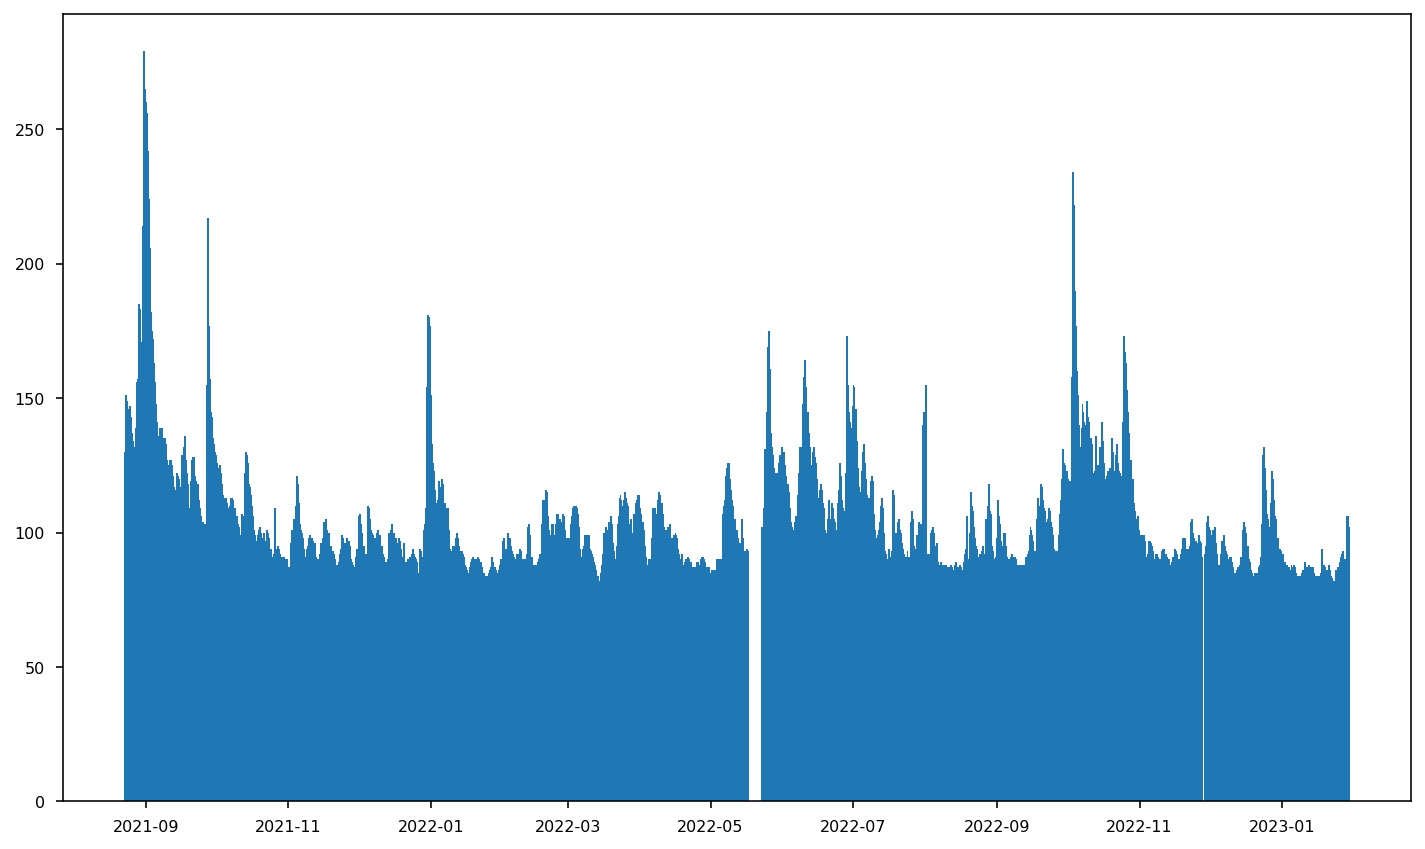

In [20]:
x_pos = np.arange(len(river_data[river_data['messstelle']=='München'].datumzeit))

fig, ax = plt.subplots()
ax.bar(x=river_data[river_data['messstelle']=='München'].datumzeit, height=river_data[river_data['messstelle']=='München'].wasserstandcm)
#ax.set_xticks(x_pos, river_data[river_data['messstelle']=='München'].datumzeit)

fig.show()

In [21]:
river_data[river_data['messstelle'] == 'München']

,messstelle,gewässer,datumzeit,wasserstandcm,änderungseit2stdcm,abflussms,meldestufe
294,München,Isar,2023-01-29 19:00:00,82,0,230.0,0
861,München,Isar,2023-01-29 18:00:00,82,0,230.0,0
1345,München,Isar,2023-01-29 17:00:00,100,-2,378.0,0
1941,München,Isar,2023-01-29 16:00:00,100,-4,378.0,0
2448,München,Isar,2023-01-29 15:00:00,102,-2,400.0,0
...,...,...,...,...,...,...,...
4823564,München,Isar,2021-08-23 04:00:00,131,1,905.0,0
4823811,München,Isar,2021-08-23 03:00:00,130,1,889.0,0
4824084,München,Isar,2021-08-23 02:00:00,130,1,889.0,0
4824503,München,Isar,2021-08-23 01:00:00,129,-2,875.0,0
